## Conversational RAG

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [3]:
from typing import List
from haystack.utils import Secret
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat.openai import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage
from haystack.components.joiners import BranchJoiner

In [4]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever


In [4]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

In [5]:
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy

Let's add more documents to our Elastic Document Store

In [6]:
converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

In [7]:
indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

In [9]:
indexing_pipeline.run({"converter": {"sources": ['data/George_RR_Martin.txt']}})

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


{'writer': {'documents_written': 72}}

In [10]:
document_store.count_documents()

127

### Create an OpenAIChatGenerator
The [`OpenAIChatGenerator`](https://docs.haystack.deepset.ai/docs/openaichatgenerator?utm_campaign=developer-relations&utm_source=dlai) allows chat completions using OpenAI LLMs. 

Messages can come from the following roles:
- system
- assistant
- user

In [11]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))
replies = chat_generator.run(messages=[ChatMessage.from_user("What was written by George Martin?")])

In [12]:
rich.print(replies['replies'][0])

ChatMessage(
    content='George R.R. Martin is best known for his epic fantasy series "A Song of Ice and Fire," which serves as
the basis for the popular television series "Game of Thrones." The main books in the series include:\n\n1. **A Game
of Thrones** (1996)\n2. **A Clash of Kings** (1998)\n3. **A Storm of Swords** (2000)\n4. **A Feast for Crows** 
(2005)\n5. **A Dance with Dragons** (2011)\n\nHe is also working on two forthcoming novels, titled **The Winds of 
Winter** and **A Dream of Spring**.\n\nIn addition to the "A Song of Ice and Fire" series, Martin has written 
numerous short stories, novellas, and other works, including:\n\n- **The Hedge Knight** (a novella set in the "A 
Song of Ice and Fire" universe)\n- **Fevre Dream** (1982)\n- **Sandkings** (1979)\n- **The Armageddon Rag** 
(1983)\n\nBeyond fiction, Martin has contributed to various anthologies and has worked as a television producer and
screenwriter.',
    role=<ChatRole.ASSISTANT: 'assistant'>,
    name=None,
    meta={
        'model': 'gpt-4o-mini-2024-07-18',
        'index': 0,
        'finish_reason': 'stop',
        'usage': {
            'completion_tokens': 235,
            'prompt_tokens': 14,
            'total_tokens': 249,
            'completion_tokens_details': CompletionTokensDetails(
                audio_tokens=0,
                reasoning_tokens=0,
                accepted_prediction_tokens=0,
                rejected_prediction_tokens=0
            ),
            'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)
        }
    }
)

In [13]:
from haystack.components.converters import OutputAdapter

In [14]:
system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. If question can't be answered exclusive from supporting documents, say so.

    Conversation history:
    {% for memory in memories %}
        {{ memory.content }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""

user_message = ChatMessage.from_user(user_message_template)

In [15]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        Conversation history:
        {% for memory in memories %}
            {{ memory.content }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

In [41]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


chat_agent = Pipeline()
chat_agent.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
chat_agent.add_component("query_rephrase_llm", OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN)))
chat_agent.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))
chat_agent.add_component("query_embedder", SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2"))
chat_agent.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3))
chat_agent.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
chat_agent.add_component("generator", chat_generator)




chat_agent.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
chat_agent.connect("query_rephrase_llm.replies", "list_to_str_adapter")
chat_agent.connect("list_to_str_adapter.output", "query_embedder.text")
chat_agent.connect("query_embedder.embedding", "retriever.query_embedding")

# connections for RAG
chat_agent.connect("retriever.documents", "prompt_builder.documents")
chat_agent.connect("prompt_builder.prompt", "generator.messages")





🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> query_embedder.text (str)
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.messages (List[ChatMessage])

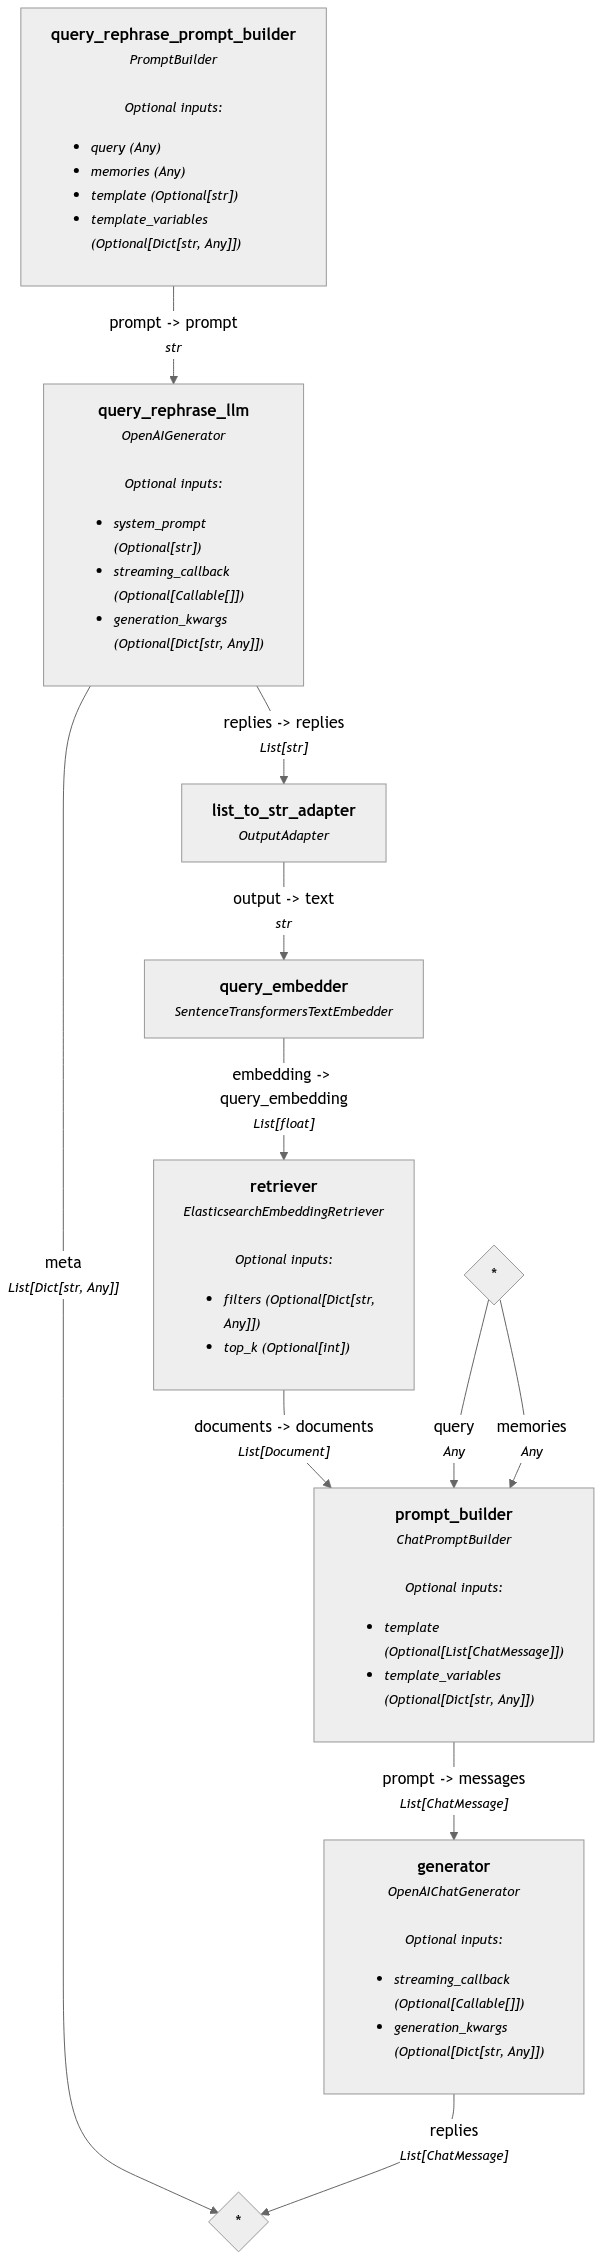

In [42]:
chat_agent.show()

In [44]:
messages = []
template = [system_message, user_message]
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    print(user_input)
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    response = chat_agent.run({"query_rephrase_prompt_builder": {"query": user_input, "memories":messages}, 
                               "prompt_builder": {"template":template, "query": user_input, "memories":messages},},
                                include_outputs_from={"message_collector", "generator"})
    messages.append(ChatMessage.from_user(user_input))
    messages.extend(response['generator']['replies'])
    print(response['generator']['replies'][0].content)




exit


In [20]:
response

{'query_rephrase_llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 4,
     'prompt_tokens': 310,
     'total_tokens': 314,
     'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'generator': {'replies': [ChatMessage(content='Yes, I am sure that the first book mentioned is *The Hobbit*.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 15, 'prompt_tokens': 323, 'total_tokens': 338, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}})]}}

In [21]:
messages

[ChatMessage(content='Who is Tolkien?', role=<ChatRole.USER: 'user'>, name=None, meta={}),
 ChatMessage(content='Tolkien, or John Ronald Reuel Tolkien, was a renowned author best known for his contributions to high fantasy literature, born on January 3, 1892, in Bloemfontein, South Africa.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 43, 'prompt_tokens': 192, 'total_tokens': 235, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}),
 ChatMessage(content='Tell me about him', role=<ChatRole.USER: 'user'>, name=None, meta={}),
 ChatMessage(content='J.R.R. Tolkien was a renowned author, best known for his high fantasy works, particularly *The Hobbit* and *The Lord of the Rings*. He was born on Januar